# Titanic Survival Model demo

In this notebook we demonstrate the use of the titanic_survival_model package. Given a ML model (here we'll use scikit-learn `LogisticRegression()`), the package loads the Titanic dataset and allows us to:

- Make prediction with the model
- Visualize the model output (input may or may not contain ground truth)
- Measure the model performance (assuming input contains ground truth)
- Update the model, keeping track of all models
- Visualize history of models performance

I haven't had time to cover all the aspects I wanted for this project, the points of improvements are indicated by the suffix **[POINTS OF IMPROVEMENT]**.

**Tools and resources for development**:

During the development of this package I used the assistance of several tools and resources, mainly:
- ChatGPT (the chat history can be found [here](https://chatgpt.com/share/6925adc3-451c-8007-ba9c-da4e85f8f322))
- Google, including the AI overview tool (chat history unavailable)
- Stackoverflow

## Imports

In [1]:
from titanic_survival_model.data import loader 
from titanic_survival_model.config import load_config
from titanic_survival_model.model import inference, training, registry
from titanic_survival_model.metrics import evaluation, monitoring, visualization

import pandas as pd
from  pprint import pprint
import random
from sklearn.linear_model import LogisticRegression

## Utils

Let's write a function that allows to create synthetic data based on the Titanic dataset.

In particular, the function will have parameters allowing to adjust the created dataset:

- `age_impact` is a [0,1] float determining how important age is for survival: when closer to 0, age is independent of survival; when reaching 1, people aged 18-30 have 100% chances of survival while older people have none.
- `survival_rate` is a [0,1] float determining the overall rate of survival of the generated batch. At 0, nobody survives, while at 1, everyone survives. 

In [12]:
def generate_synthetic_titanic(batch_size: int, age_impact: float, survival_rate: float):
    
    assert batch_size > 0, "batch_size must be positive"
    assert 0 <= age_impact <= 1, "age_impact must be in [0, 1]"
    assert 0 <= survival_rate <= 1, "survival_rate must be in [0, 1]"

    age_low = 18
    age_high = 100 - age_impact * 70

    data = {
        "Pclass": [random.choice([1, 2, 3]) for _ in range(batch_size)],
        "Sex": [random.choice([0, 1]) for _ in range(batch_size)],
        "Fare": [random.uniform(0, 500) for _ in range(batch_size)],
        "Survived": [1 if random.random() < survival_rate else 0 for _ in range(batch_size)]
    }

    age = []

    for survived in data["Survived"]:
        if random.random() < age_impact:
            if survived == 1:
                age.append(random.randint(18, 30))
            else:
                age.append(random.randint(31, 100))
        else:
            age.append(random.randint(18, 100))

    data["Age"] = age

    return pd.DataFrame(data)

## Loading the data

The initial data is loaded from the following URL, only keeping the following features: "Pclass", "Sex", "Age", "Fare".
`https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv`

In [3]:
X, y = loader.load_titanic()

## Training the model

The specified model is trained. I assumed using scikit-learn's `LogisticRegression()` model; in theory any model with the `.fit()`, `.predict()` and `.predict_proba()` methods can be used.

Training currently doesn't support hyperparameter tuning. Performance is measured and recorded during training **on the test set only**, which is a weakness of the current implementation.

This method allows retraining whenever needed.

**When should a model be retrained?**

This question is tied to business and operational costs, and depends on how much it costs to retrain, how much new data is available, and how much model degradation costs. A few points to consider:

- If training cost are low, a regular retraining schedule (e.g. once a month, provided new data is available) could be implemented.
- Alternatively, and especially when training cost are significant, keeping track of the most important performance metrics (which are decided based on business cost and target) and setting thresholds is a good idea.
- When retraining, it's worth observing for any concept drift. If any drift is observed (e.g. features distribution changes), discarding past data and only retaining the most recent one is the way to go.
- Depending on the nature of business and related data, seasonality could also be a phenomenon to track, in which case time of new data obtention should be recorded, and we could either make sure that models are trained over data spread across all periods of the seasonality, or train several models, one for each period of the seasonality.

**[POINTS OF IMPROVEMENT]**:
- Verify that other models can be used.
- Implement hyperparameter tuning
- Implement proper performance metric calculation: run cross-validation, compute performance metrics on each validation run, record mean and standard deviation of all performance metrics across all validations.

In [4]:
model = LogisticRegression()

trained_model, _ = training.train(model, X, y)

## Note on metrics

For the sake of generalization, the following metrics are being tracked:

- **input metrics** (if ground truth is known):
  - positive/negative count
  - positive rate
- **prediction metrics** (most useful metrics when ground truth is not known, as it allows to track output distribution and indicate model behavior drift even when ground truth is not known):
  - predicted positive/negative counts
  - predicted positive rate
  - min/max, mean and standard deviation of predicted score
- **performance metrics**:
  - confusion matrix
  - accuracy (not the most informative metric but useful for layman-oriented presentations, such as marketing and sales)
  - ROC AUC, PR AUC, F1 score, log loss (assuming we don't know the class distribution and business importance/cost of true/false positive/negative, it's best to keep an eye on all four metrics)
  - ROC curve, PR curve (for performance visualization)

**[POINTS OF IMPROVEMENT]**:
- One big metric missing is distribution on input features. Keeping track of those is important as it can signal when to retrain a model, or inform model performance degradation.

## Making inference on new data and visualizing

Given new data, the program can make new inference and produce metrics based on that inference batch.

**Important note**: this project is specifically designed for manual implementation of metrics visualization. In a production environment, the way to go would be to use a 3rd-party product such as Weights and Biases offering off-the-shelf model performance tracking and versioning.

In [11]:
new_data = generate_synthetic_titanic(100, 0, 0.5)

new_X = new_data.drop('Survived', axis=1)
new_y = new_data['Survived']

#### No ground truth

In the case when ground truth is not known, prediction score distribution as well as data features distribution (not implemented here) are the main things to track and visualize.

In [12]:
# Inference without ground truth

inference_without_truth = inference.predict(trained_model, new_X)

pprint(inference_without_truth)

Prediction(metrics=Metrics(input=InputMetrics(batch_size=100,
                                              positive_count=None,
                                              negative_count=None,
                                              positive_rate=None),
                           prediction=PredictionMetrics(positive_rate=0.24,
                                                        positive_count=24,
                                                        negative_count=76,
                                                        min_score=0.00551420612969775,
                                                        mean_score=0.29270910234584235,
                                                        max_score=0.939605543660379,
                                                        score_std=0.2598963077109022),
                           performance=PerformanceMetrics(confusion_matrix=None,
                                                          accuracy=None,
          

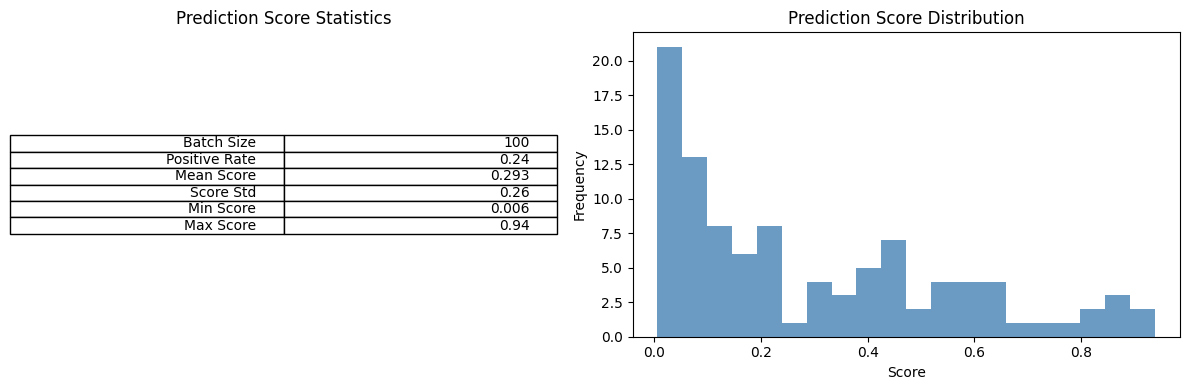

In [13]:
visualization.visualize_without_ground_truth(inference_without_truth)

#### Ground truth available

In the case when ground truth is available, aside from the metrics presented in the previous section, confusion matric, ROC AUC, PR AUC, precision, recall, F1 score, log loss, and ROC/PR curves are the main performance metrics to track.

In [14]:
# Inference with ground truth

inference_with_truth = inference.predict(trained_model, new_X, new_y)

pprint(inference_with_truth)

Prediction(metrics=Metrics(input=InputMetrics(batch_size=100,
                                              positive_count=38,
                                              negative_count=62,
                                              positive_rate=0.38),
                           prediction=PredictionMetrics(positive_rate=0.24,
                                                        positive_count=24,
                                                        negative_count=76,
                                                        min_score=0.00551420612969775,
                                                        mean_score=0.29270910234584235,
                                                        max_score=0.939605543660379,
                                                        score_std=0.2598963077109022),
                           performance=PerformanceMetrics(confusion_matrix=[[48,
                                                                             14],
     

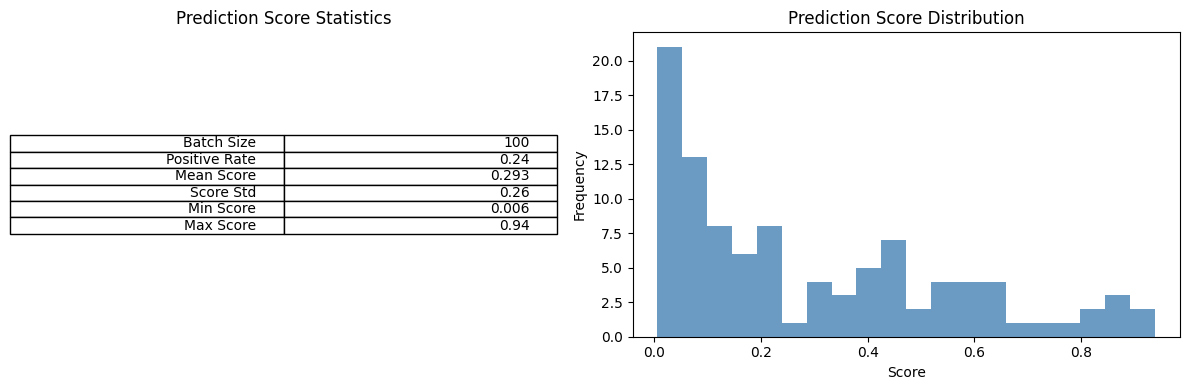

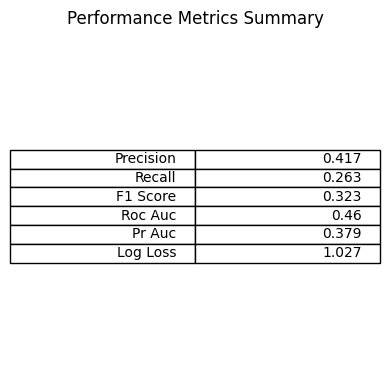

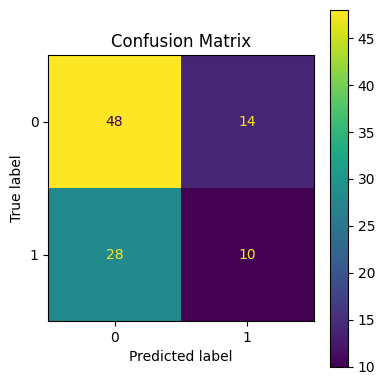

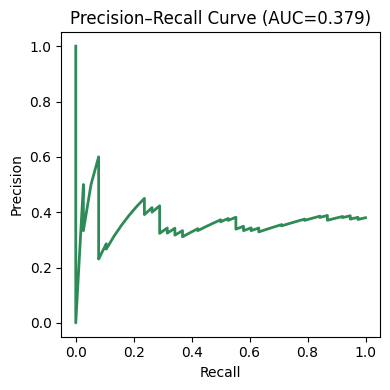

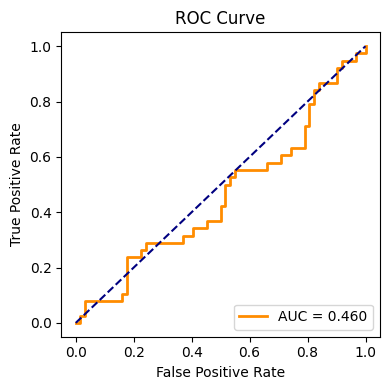

In [17]:
figs = visualization.visualize_with_ground_truth(inference_with_truth)

for fig in figs:
    display(fig)

## Track model training history

### Example: survival rate goes down and age becomes more and more determinant

This is an example of tracking model performance across several trainings. The data evolves as follows across successive new datasets:
- age becomes the best predictor for survival (thus making the model more performant),
- rate of survival shifts from 90% to 10%.

We observe the following metric evolution:
- ROC AUC is not affected by change in rate of survival since it is not sensitive to class imbalance. It does however drift towards 1 as time progresses, since age becomes a perfect predictor of survival.
- PR AUC sees a double effect, leading to a valley-shaped evolution
  - It declines as positive rate goes down
  - But increases as model predictive power increases (through age feature).
- F1 score sees a similar effect, although, being even more sensitive than PR AUC to postive rates, we can see it being initially stable, but, as positive rate goes down, becoming more volatile
- Log loss goes through a hill-shaped curve:
  - The model predicts the majority class correctly most of the time, so log loss stays low despite having no informative features.
  - Then, the model is forced to make real predictions but lacks strong guidance, producing many miscalibrated, wrong, or uncertain predictions, causing log loss to spike.
  - Finally, age becomes fully predictive, enabling perfectly confident and accurate predictions, so log loss collapses to zero, even under heavy class imbalance.

In [25]:
for i in range(100):

    evolving_data = generate_synthetic_titanic(
        1000,
        i/100,
        0.9-i/125
    )

    evolving_X = evolving_data.drop('Survived', axis=1)
    evolving_y = evolving_data['Survived']

    training.train(model, evolving_X, evolving_y)

In [26]:
history = monitoring.collect_performance_history()

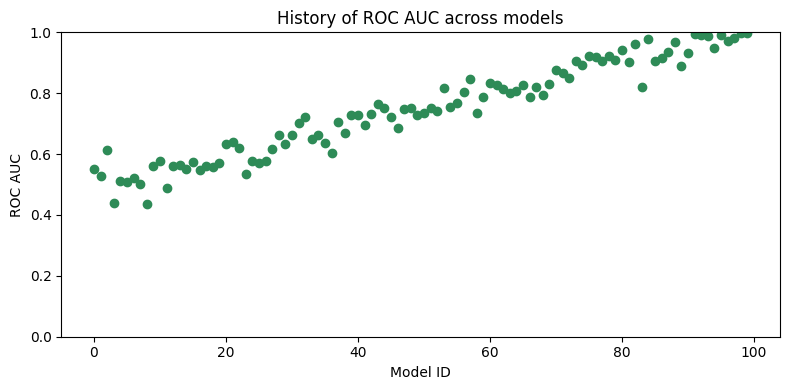

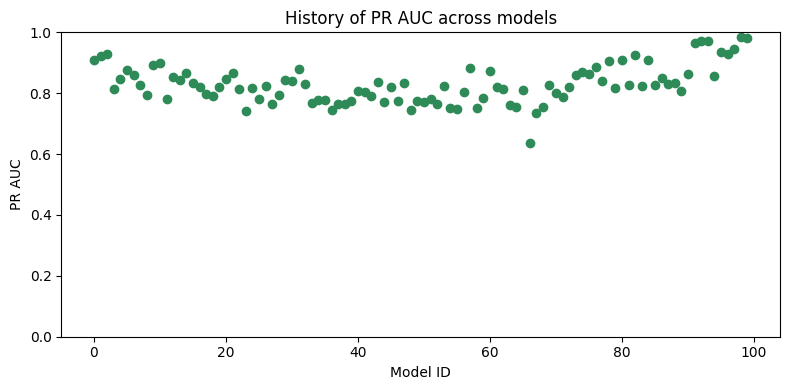

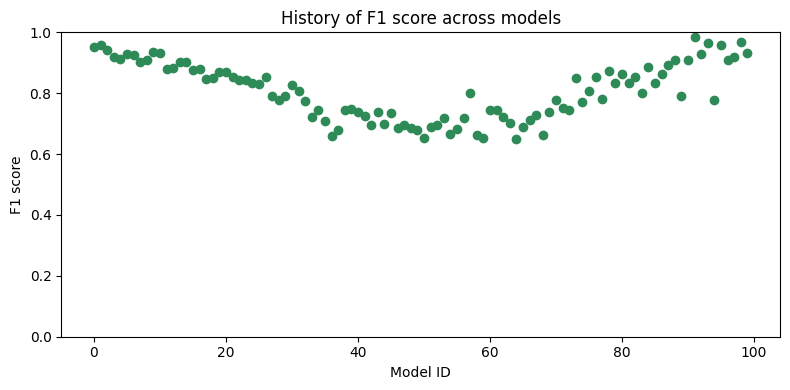

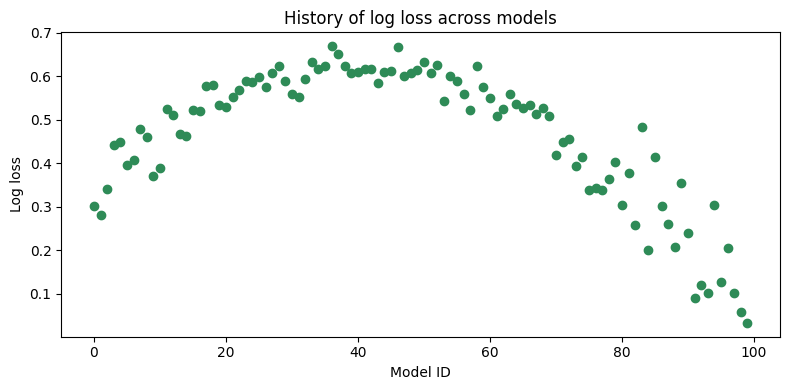

In [27]:
figs = visualization.visualize_performance_history(history)

for fig in figs:
    display(fig)